# Control

Convex optimization can be used to solve many problems that arise in control.
In this example we show how to solve such a problem using CVXPY.
We have a system with a state $x_t\in {\bf R}^n$ that varies over the time steps $t=0,\ldots,T$, and inputs or actions $u_t\in {\bf R}^m$ we can use at each time step to affect the state.
For example, $x_t$ might be the position and velocity of a rocket and $u_t$ the output of the rocket's thrusters.
We model the evolution of the state as a linear dynamical system, i.e.,

$$ x_{t+1} = Ax_t + Bu_t $$

where $A \in {\bf R}^{n\times n}$ and $B \in {\bf R}^{n\times m}$ are known matrices.

Our goal is to find the optimal actions $u_0,\ldots,u_{T-1}$ by solving the optimization problems

\begin{array}{ll} \mbox{minimize} & \sum_{t=0}^{T-1} \ell (x_t,u_t) + \ell_T(x_T)\\
\mbox{subject to} & x_{t+1} = Ax_t + Bu_t\\%, \quad t=0, \ldots, T-1\\
& (x_t,u_t) \in \mathcal C, \quad x_T\in \mathcal C_T,
%, \quad \quad t=0, \ldots, T
\end{array}

where $\ell: {\bf R}^n \times {\bf R}^m\to {\bf R}$ is the stage cost, $\ell_T$ is the terminal cost,
$\mathcal C$ is the state/action constraints, and $\mathcal C_T$ is the terminal constraint.
The optimization problem is convex if the costs and constraints are convex.


### Example

In the following code we solve a control problem with $n=8$ states, $m=2$ inputs, and horizon $T=50$.
The matrices $A$ and $B$ and the initial state $x_0$ are randomly chosen (with $A\approx I$).
We use the (traditional) stage cost $\ell(x,u) = \|x\|_2^2 + \|u\|_2^2$, the input constraint $\|u_t\|_\infty \leq 1$, and the terminal constraint $x_{T}=0$.

In [73]:
# Generate data for control problem.
import numpy as np
np.random.seed(1)
n = 8 # 状态维度
m = 2 # 输入维度
T = 50 # 时域长度
alpha = 0.2 # 紧凑型随机矩阵的系数
beta = 5 # 初始状态的系数
A = np.eye(n) + alpha*np.random.randn(n,n) # 使用 NumPy 生成一个大小为 (n,n) 的单位矩阵，并在其上加上一个紧凑型随机矩阵, 状态转移矩阵
B = np.random.randn(n,m) # 使用 NumPy 生成一个大小为 (n,m) 的随机矩阵, 输入矩阵
x_0 = beta*np.random.randn(n) # 使用 NumPy 生成一个大小为 (n,) 的随机向量， 初始状态

In [74]:
# Form and solve control problem.
import cvxpy as cp

x = cp.Variable((n, T+1)) # 使用 CVXPY 生成一个大小为 (n,T+1) 的变量矩阵，状态矩阵
u = cp.Variable((m, T)) # 使用 CVXPY 生成一个大小为 (m,T) 的变量矩阵，输入矩阵

cost = 0 # 经验损失
constr = [] # 约束条件
for t in range(T):
    cost += cp.sum_squares(x[:,t+1]) + cp.sum_squares(u[:,t]) # sums stage costs.
    constr += [x[:,t+1] == A@x[:,t] + B@u[:,t], # dynamic constraints.
               cp.norm(u[:,t], 'inf') <= 1] # input constraints.
# sums problem objectives and concatenates constraints.
constr += [x[:,T] == 0, x[:,0] == x_0]
problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve(solver=cp.ECOS)

E:\python\lib\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


64470.63768245135

In [56]:
# no obstacle
import numpy as np
import cvxpy as cp

# Generate data for control problem.
np.random.seed(1)
n = 2  # 状态维度
m = 2  # 输入维度
T = 15  # 时域长度
A = np.eye(n)  # 使用 NumPy 生成一个大小为 (n,n) 的单位矩阵 状态转移矩阵
B = np.eye(n)  # 使用 NumPy 生成一个大小为 (n,n) 的单位矩阵 输入矩阵
x_0 = [0.1, 5]  # 初始状态
x_t = [0, -5]  # 终止状态

# Form and solve control problem.
x = cp.Variable((n, T+1)) # 使用 CVXPY 生成一个大小为 (n,T+1) 的变量矩阵，状态矩阵
u = cp.Variable((m, T)) # 使用 CVXPY 生成一个大小为 (m,T) 的变量矩阵，输入矩阵

cost = 0 # 经验损失
constr = [] # 约束条件
for t in range(T):
    cost += cp.sum_squares(x[:,t+1] - x[:,t]) + cp.sum_squares(u[:,t]) # sums stage costs.
    constr += [x[:,t+1] == A@x[:,t] + B@u[:,t], # dynamic constraints.
               cp.norm(u[:,t], 'inf') <= 1] # input constraints.
# sums problem objectives and concatenates constraints.
constr += [x[:,T] == x_t, x[:,0] == x_0] # terminal constraint, initial condition.
problem = cp.Problem(cp.Minimize(cost), constr) # 生成优化问题
problem.solve(solver=cp.ECOS) # 求解优化问题
print("optimal cost:", problem.value) # 输出优化问题的最优值
print("optimal position:\n", x.value) # 输出优化问题的最优解

optimal cost: 13.33466666660105
optimal position:
 [[ 1.00000000e-01  9.33333345e-02  8.66666685e-02  8.00000021e-02
   7.33333354e-02  6.66666683e-02  6.00000012e-02  5.33333338e-02
   4.66666665e-02  3.99999991e-02  3.33333319e-02  2.66666649e-02
   1.99999981e-02  1.33333317e-02  6.66666561e-03  4.31701885e-14]
 [ 5.00000000e+00  4.33333345e+00  3.66666684e+00  3.00000020e+00
   2.33333353e+00  1.66666683e+00  1.00000010e+00  3.33333369e-01
  -3.33333369e-01 -1.00000010e+00 -1.66666683e+00 -2.33333353e+00
  -3.00000020e+00 -3.66666684e+00 -4.33333345e+00 -5.00000000e+00]]


In [57]:
# a circular obstacle at point (0, 0) and its radius is 2
import numpy as np
import cvxpy as cp

# Generate data for control problem.
np.random.seed(1)
n = 2  # 状态维度
m = 2  # 输入维度
T = 15  # 时域长度
A = np.eye(n)  # 使用 NumPy 生成一个大小为 (n,n) 的单位矩阵 状态转移矩阵
B = np.eye(n)  # 使用 NumPy 生成一个大小为 (n,n) 的单位矩阵 输入矩阵
x_0 = [0.1, 5]  # 初始状态
x_t = [0, -5]  # 终止状态

# Form and solve control problem.
x = cp.Variable((n, T+1)) # 使用 CVXPY 生成一个大小为 (n,T+1) 的变量矩阵，状态矩阵
u = cp.Variable((m, T)) # 使用 CVXPY 生成一个大小为 (m,T) 的变量矩阵，输入矩阵

cost = 0 # 经验损失
constr = [] # 约束条件
for t in range(T):
    # 构造闸函数
    # 闸函数的定义为：g(x) = 0, 4 - cp.norm(x[:,t], 2) <= 0 ，g(x) = +inf, 4 - cp.norm(x[:,t], 2) > 0
    # barrier_func = -cp.log(cp.sum_squares(x[:,t]) - 4) # sums stage costs.
    cost += cp.sum_squares(x[:,t+1] - x[:,t]) + cp.sum_squares(u[:,t]) # sums stage costs.
    if t < 8:
        constr += [x[:,t+1] == A@x[:,t] + B@u[:,t], # dynamic constraints.
                   cp.norm(u[:,t], 'inf') <= 1, # input constraints.
                   # 半平面约束
                   -cp.sqrt(21) / 2 * x[0,t] - x[1,t] + 5 <= 0]
    if t >= 8:
        constr += [x[:,t+1] == A@x[:,t] + B@u[:,t], # dynamic constraints.
                   cp.norm(u[:,t], 'inf') <= 1, # input constraints.
                   cp.sqrt(21) / 2 * x[0,t] - x[1,t] - 5 >= 0]
    # if t == 8:
    #     constr += [x[:,t+1] == A@x[:,t] + B@u[:,t], # dynamic constraints.
    #                cp.norm(u[:,t], 'inf') <= 1] # input constraints.

# sums problem objectives and concatenates constraints.
constr += [x[:,T] == x_t, x[:,0] == x_0] # terminal constraint, initial condition.
problem = cp.Problem(cp.Minimize(cost), constr) # 生成优化问题
problem.solve(solver=cp.ECOS) # 求解优化问题
print("optimal cost:", problem.value) # 输出优化问题的最优值
print("optimal position:\n", x.value) # 输出优化问题的最优解

optimal cost: 15.561826347020638
optimal position:
 [[ 1.00000000e-01  3.73465431e-01  6.46930824e-01  9.20396216e-01
   1.19386162e+00  1.46732704e+00  1.74079244e+00  2.01425784e+00
   2.00931957e+00  1.72228263e+00  1.43524588e+00  1.14820476e+00
   8.61159928e-01  5.74111467e-01  2.87058862e-01 -5.96254536e-12]
 [ 5.00000000e+00  4.34067935e+00  3.68135870e+00  3.02203806e+00
   2.36271741e+00  1.70339678e+00  1.04407614e+00  3.84755490e-01
  -3.96070479e-01 -1.05377852e+00 -1.71148663e+00 -2.36919282e+00
  -3.02689738e+00 -3.68460037e+00 -4.34230155e+00 -5.00000000e+00]]


In [60]:
# a circular obstacle at point (1, 1) and its radius is 1 and a circular obstacle at point (-0.9, -1) and its radius is 1
import numpy as np
import cvxpy as cp

# Generate data for control problem.
np.random.seed(1)
n = 2  # 状态维度
m = 2  # 输入维度
T = 15  # 时域长度
A = np.eye(n)  # 使用 NumPy 生成一个大小为 (n,n) 的单位矩阵 状态转移矩阵
B = np.eye(n)  # 使用 NumPy 生成一个大小为 (n,n) 的单位矩阵 输入矩阵
x_0 = [0.1, 5]  # 初始状态
x_t = [0, -5]  # 终止状态

# Form and solve control problem.
x = cp.Variable((n, T+1)) # 使用 CVXPY 生成一个大小为 (n,T+1) 的变量矩阵，状态矩阵
u = cp.Variable((m, T)) # 使用 CVXPY 生成一个大小为 (m,T) 的变量矩阵，输入矩阵

cost = 0 # 经验损失
constr = [] # 约束条件
for t in range(T):
    # 构造闸函数
    # 闸函数的定义为：g(x) = 0, 4 - cp.norm(x[:,t], 2) <= 0 ，g(x) = +inf, 4 - cp.norm(x[:,t], 2) > 0
    # barrier_func = -cp.log(cp.sum_squares(x[:,t]) - 4) # sums stage costs.
    cost += cp.sum_squares(x[:,t+1] - x[:,t]) + cp.sum_squares(u[:,t]) # sums stage costs.
    if 6 <= t < 7:
        constr += [x[:,t+1] == A@x[:,t] + B@u[:,t], # dynamic constraints.
                   cp.norm(u[:,t], 'inf') <= 1, # input constraints.
                   x[0,t] <= 0]
    else:
        if 9 <= t < 10:
            constr += [x[:,t+1] == A@x[:,t] + B@u[:,t], # dynamic constraints.
                       cp.norm(u[:,t], 'inf') <= 1, # input constraints.
                       # 半平面约束
                       x[0,t] >= 0.1]
        else:
            constr += [x[:,t+1] == A@x[:,t] + B@u[:,t], # dynamic constraints.
                       cp.norm(u[:,t], 'inf') <= 1] # input constraints.

# sums problem objectives and concatenates constraints.
constr += [x[:,T] == x_t, x[:,0] == x_0] # terminal constraint, initial condition.
problem = cp.Problem(cp.Minimize(cost), constr) # 生成优化问题
problem.solve(solver=cp.ECOS) # 求解优化问题
print("optimal cost:", problem.value) # 输出优化问题的最优值
print("optimal position:\n", x.value) # 输出优化问题的最优解

optimal cost: 13.34666667142475
optimal position:
 [[ 1.00000000e-01  8.33333266e-02  6.66666564e-02  4.99999891e-02
   3.33333242e-02  1.66666611e-02 -5.40507891e-10  3.33333331e-02
   6.66666669e-02  1.00000001e-01  8.33333389e-02  6.66666758e-02
   5.00000108e-02  3.33333435e-02  1.66666734e-02  5.01262015e-13]
 [ 5.00000000e+00  4.33332724e+00  3.66665448e+00  2.99998172e+00
   2.33330896e+00  1.66663620e+00  9.99963434e-01  3.33321145e-01
  -3.33321145e-01 -9.99963434e-01 -1.66663620e+00 -2.33330896e+00
  -2.99998172e+00 -3.66665448e+00 -4.33332724e+00 -5.00000000e+00]]


We display the results below as a $4$-high stack of plots showing $u_1$, $u_2$, $x_1$, and $x_2$ vs $t$.
Notice that $u_t$ is saturated (i.e., $\|u_t\|_\infty = 1$) over more than half of the horizon, which shows that the input constraint is meaningful.

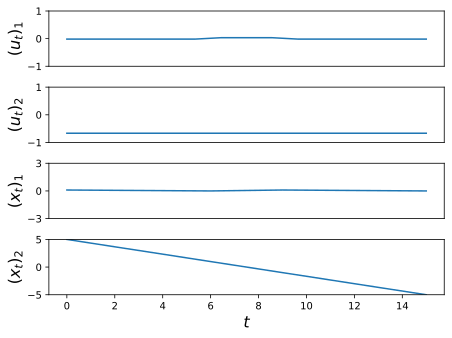

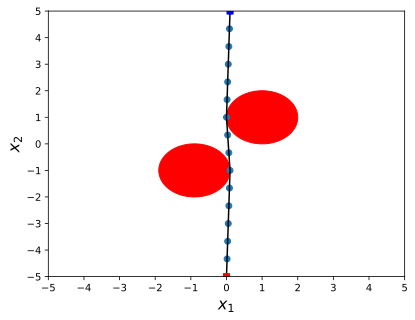

In [61]:
# Plot results.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

f = plt.figure()

# Plot (u_t)_1.
ax = f.add_subplot(411)
plt.plot(u[0,:].value)
plt.ylabel(r"$(u_t)_1$", fontsize=16)
plt.yticks(np.linspace(-1.0, 1.0, 3))
plt.xticks([])

# Plot (u_t)_2.
plt.subplot(4,1,2)
plt.plot(u[1,:].value)
plt.ylabel(r"$(u_t)_2$", fontsize=16)
plt.yticks(np.linspace(-1, 1, 3))
plt.xticks([])

# # Plot (x_t)_1.
# plt.subplot(4,1,3)
# x1 = x[0,:].value
# plt.plot(x1)
# plt.ylabel(r"$(x_t)_1$", fontsize=16)
# plt.yticks([-10, 0, 10])
# plt.ylim([-10, 10])
# plt.xticks([])
#
# # Plot (x_t)_2.
# plt.subplot(4,1,4)
# x2 = x[1,:].value
# plt.plot(range(51), x2)
# plt.yticks([-25, 0, 25])
# plt.ylim([-25, 25])
# plt.ylabel(r"$(x_t)_2$", fontsize=16)
# plt.xlabel(r"$t$", fontsize=16)
# plt.tight_layout()
# plt.show()

# Plot (x_t)_1.
plt.subplot(4,1,3)
x1 = x[0,:].value
plt.plot(x1)
plt.ylabel(r"$(x_t)_1$", fontsize=16)
plt.yticks([-3, 0, 3])
plt.ylim([-3, 3])
plt.xticks([])

# Plot (x_t)_2.
plt.subplot(4,1,4)
x2 = x[1,:].value
plt.plot(range(16), x2)
plt.yticks([-5, 0, 5])
plt.ylim([-5, 5])
plt.ylabel(r"$(x_t)_2$", fontsize=16)
plt.xlabel(r"$t$", fontsize=16)
plt.tight_layout()
plt.show()

# 在一个新的绘图窗口中绘制点的轨迹，并明显标识出每个点
plt.figure()
plt.plot(x1, x2, 'o')
plt.plot(x1, x2, 'k-')
plt.plot(x_0[0], x_0[1], 'bs')
plt.plot(x_t[0], x_t[1], 'rs')
plt.xlabel(r"$x_1$", fontsize=16)
plt.ylabel(r"$x_2$", fontsize=16)

# 绘制障碍物1
# circle1 = plt.Circle((0, 0), 2, color='r')
# plt.gcf().gca().add_artist(circle1)
# plt.axis([-3, 3, -5, 5])
# plt.xticks(np.linspace(-5, 5, 11))
# plt.yticks(np.linspace(-5, 5, 11))
# plt.show()

# 绘制障碍物 2 和 3
circle2 = plt.Circle((1, 1), 1, color='r')
plt.gcf().gca().add_artist(circle2)
circle3 = plt.Circle((-0.9, -1), 1, color='r')
plt.gcf().gca().add_artist(circle3)
plt.axis([-5, 5, -5, 5])
plt.xticks(np.linspace(-5, 5, 11))
plt.yticks(np.linspace(-5, 5, 11))
plt.show()